In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mount to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


load the data

In [3]:
## Load the data
training_file = "/content/drive/MyDrive/German Traffic Sign/train.p"
testing_file = "/content/drive/MyDrive/German Traffic Sign/test.p"   
 
# Open and load the training file 
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
 
# Open and load the training file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Data loaded")

Data loaded


#Eksplorasi Data

membaca file signnames.csv

In [4]:
## let's create a pandas dataframe to load csv
## The content of csv file is ClassId and the SignName
 
sign_name_df = pd.read_csv('/content/drive/MyDrive/German Traffic Sign/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


mendefinisikan fitur dan label pada data pickle yang telah di-load, lalu mengonversi lists menjadi numpy array pada data train dan data test.

In [5]:
# Define features and labels for training data 
X, y = train['features'], train['labels']
 
# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)
 
# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']
 
# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [6]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


Visualisasi distribusi kelas pada data training, validating, testing.

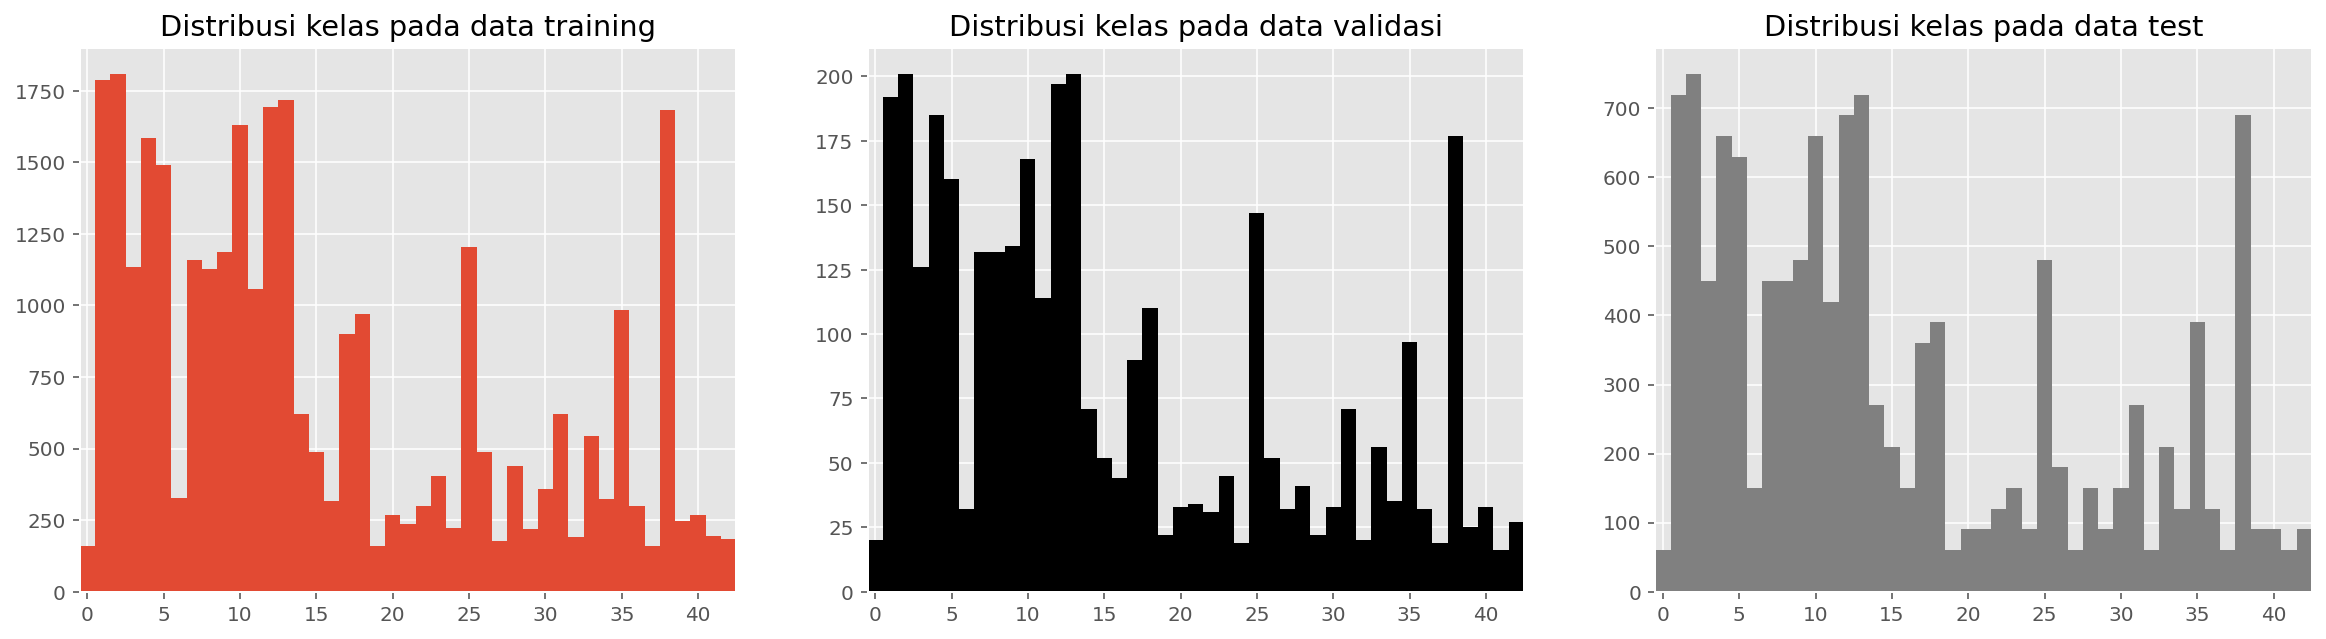

In [7]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

ifnormasi dari hasil visualisasi: distribusi kelas masing-masing bagian data terlihat mirip

# Data Preparation

mengonversi label pada data training dan validasi dengan teknik one hot encoding.

Mengubah label dari tipe data string menjadi fitur kategorik menggunakan fungsi to_categorical dari library tensorflow.

In [8]:
# Converting the labels into one hot encoding
from tensorflow.keras.utils import to_categorical
 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

#Training dengan Convolutional Neural Network

mendefinisikan callbacks

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

Set parameter layer

In [10]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

Layer ke dua

In [11]:
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

Fully connected layer

In [12]:
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

Dense layer menerima input dari semua neuron pada lapisan sebelumnya.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

#Train/compile the model

In [15]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 [==============================] - 169s 172ms/step - loss: 0.2311 - accuracy: 0.9379 - val_loss: 0.0622 - val_accuracy: 0.9822
Epoch 2/25
979/979 [==============================] - 169s 173ms/step - loss: 0.2283 - accuracy: 0.9377 - val_loss: 0.0830 - val_accuracy: 0.9787
Epoch 3/25
979/979 [==============================] - 172s 175ms/step - loss: 0.2051 - accuracy: 0.9452 - val_loss: 0.0443 - val_accuracy: 0.9876
Epoch 4/25
979/979 [==============================] - 169s 173ms/step - loss: 0.2073 - accuracy: 0.9438 - val_loss: 0.0594 - val_accuracy: 0.9853
Epoch 5/25
979/979 [==============================] - 168s 171ms/step - loss: 0.2030 - accuracy: 0.9458 - val_loss: 0.0539 - val_accuracy: 0.9836
Epoch 6/25
979/979 [==============================] - 171s 174ms/step - loss: 0.1938 - accuracy: 0.9480 - val_loss: 0.0422 - val_accuracy: 0.9902
Epoch 7/25
979/979 [==============================] - 169s 173ms/step - loss: 0.1705 - accuracy: 0.9551 - val_loss: 0.0440 -

#Visualisasi *Accuracy* dan *loss*

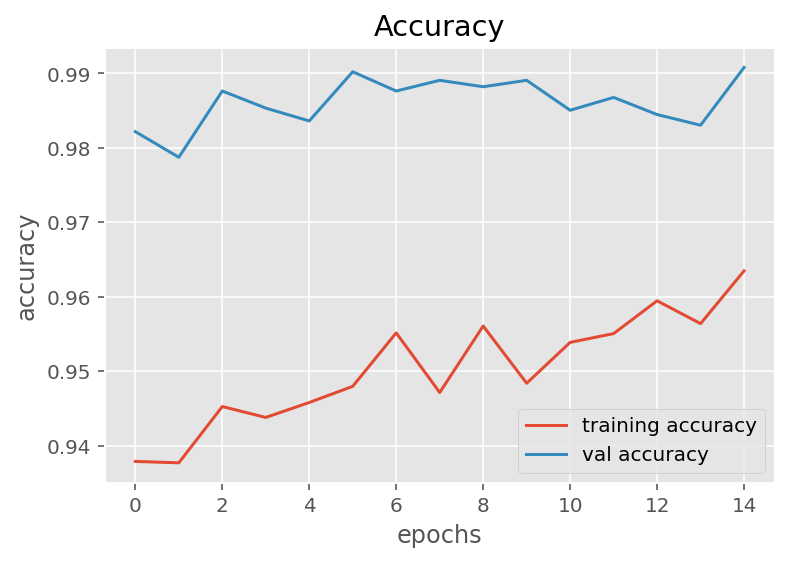

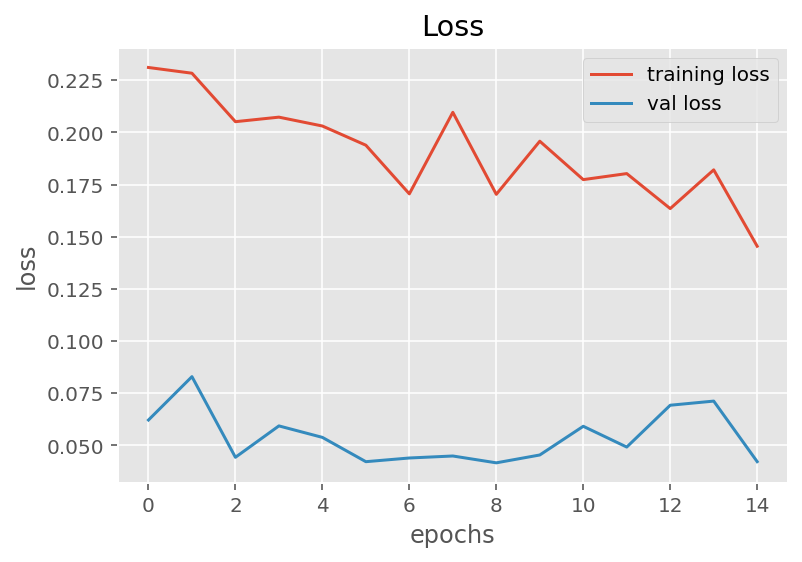

In [16]:
# Plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#Menguji Model

In [17]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score
 
pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.9646872525732383

# Metrik klasifikasi precision, recall, dan f1-score.

Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.

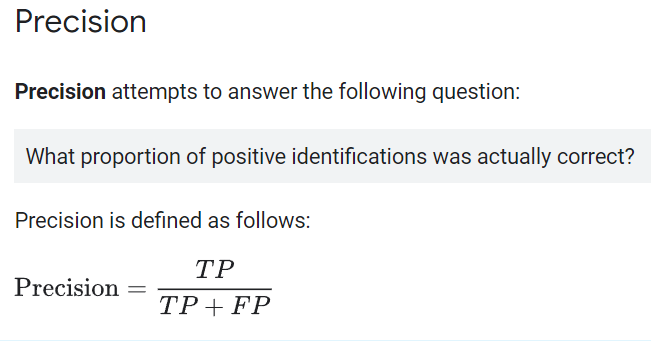

Recall is the ratio of correctly predicted positive observations to the all observations in actual class 

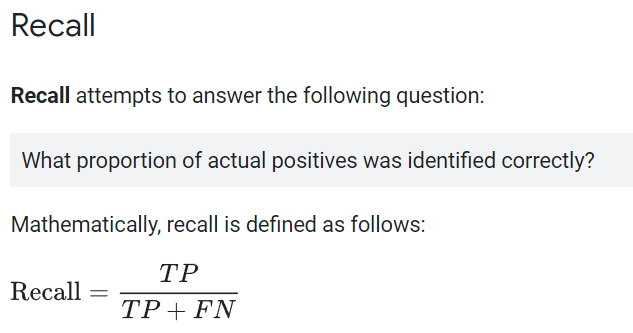

F1 Score is the weighted average of Precision and Recall

In [18]:
# Calculate metrics for classification
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        60
           1       0.96      0.99      0.98       720
           2       0.99      0.98      0.99       750
           3       0.95      0.95      0.95       450
           4       0.99      0.97      0.98       660
           5       0.94      0.94      0.94       630
           6       0.99      0.93      0.96       150
           7       0.98      0.98      0.98       450
           8       0.97      0.99      0.98       450
           9       0.97      0.99      0.98       480
          10       0.99      0.99      0.99       660
          11       0.93      0.92      0.93       420
          12       0.98      0.97      0.97       690
          13       0.98      0.99      0.99       720
          14       0.99      0.99      0.99       270
          15       0.96      1.00      0.98       210
          16       1.00      0.99      1.00       150
          17       1.00    